In [1]:
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from pygame import mixer
import time
import numpy as np

pygame 2.5.0 (SDL 2.28.0, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
model = tf.keras.models.load_model(r'C:\Users\imadc\Super Folder\modelss\MobileNet.h5')

In [3]:
def preprocess_eye(eye):
    eye = cv2.resize(eye, (80, 80))
    eye = eye / 255.0
    eye = np.expand_dims(eye, axis=0)
    return eye

# Predicting on unseen Image

In [10]:
img = r'C:\Users\imadc\Super folder\testingimages\55.jpg'  #new unseen image path to predict
frame = cv2.imread(img)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
eyes = eye_cascade.detectMultiScale(gray, minNeighbors=7, scaleFactor=1.2)

for (x, y, w, h) in eyes:
    eye = frame[y:y + h, x:x + w]
    eye = preprocess_eye(eye)
    prediction = model.predict(eye, verbose = 0 )

    probability_close = prediction[0][0]
    probability_open = prediction[0][1]
    
    probability_close_percent = probability_close * 100
    probability_open_percent = probability_open * 100

    if prediction[0][1] > prediction[0][0]:
        eye_status = "Open"                        
    else:
        eye_status = "Close"               

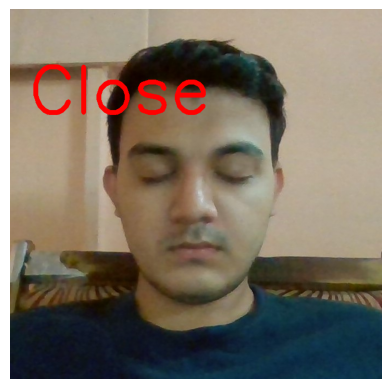

[[0.99618185 0.02834866]]
Close
Probability of Close: 99.62%
Probability of Open: 2.83%


In [11]:
import matplotlib.pyplot as plt
cv2.putText(frame, eye_status, (35,190) , cv2.FONT_HERSHEY_SIMPLEX, 4, (0 ,0 , 255), 8)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(prediction)
print(eye_status)
print(f"Probability of Close: {probability_close_percent:.2f}%")
print(f"Probability of Open: {probability_open_percent:.2f}%")


# Predicting on a Live Video

In [4]:
import cv2
import numpy as np
import os
from pygame import mixer

song = r"C:\Users\imadc\alert.wav"
mixer.init()
alert_sound = mixer.Sound(song)

cap = cv2.VideoCapture(0)
point = 0
prev_frame_time = 0

sound_flag = False

while True:
    ret, frame = cap.read()
    #print(frame.shape)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, minNeighbors=7, scaleFactor=1.2)

    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    
    if len(eyes) > 0:
        for (x, y, w, h) in eyes:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            eye = frame[y:y + h, x:x + w]
            eye = cv2.resize(eye, (80, 80))
            eye = eye / 255
            eye = eye.reshape(80, 80, 3)
            eye = np.expand_dims(eye, axis=0)
            prediction = model.predict(eye, verbose=0)

            # Condition for Close
            if prediction[0][0] > 0.50:
                point += 1

            # Condition for Open
            elif prediction[0][1] > 0.70:
                point = max(0, point - 1)

        if point > 15:
            cv2.putText(frame, 'Closed', (100, 190), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 4, cv2.FILLED)
        else:
            cv2.putText(frame, 'Open', (100, 190), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 4, cv2.FILLED)

        if point > 15 and not sound_flag:
            alert_sound.play(-1)
            sound_flag = True
        elif point <= 15:
            if sound_flag:
                alert_sound.stop()
                sound_flag = False
                
    else:
        pass

    p_txt = str(point)
    cv2.putText(frame, f'Points: {p_txt}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    cv2.imshow('Eye Status detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        alert_sound.stop()
        break
    

        
cap.release()
cv2.destroyAllWindows()

# Live Video + Live Chart

In [ ]:
import cv2
import numpy as np
import os
from pygame import mixer
import time
import matplotlib.pyplot as plt

song = r"C:\Users\imadc\alert.wav"
mixer.init()
alert_sound = mixer.Sound(song)

cap = cv2.VideoCapture(0)
point = 0
prev_frame_time = 0

sound_flag = False

points_history = []

plt.figure(figsize=(8, 4))
plt.title('Eye Status')
plt.xlabel('Frames')
plt.ylabel('Points')
plt.grid(True)

threshold = 15

while True:
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, minNeighbors=7, scaleFactor=1.2)

    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time

    if len(eyes) > 0:
        for (x, y, w, h) in eyes:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            eye = frame[y:y + h, x:x + w]
            eye = cv2.resize(eye, (80, 80))
            eye = eye / 255
            eye = eye.reshape(80, 80, 3)
            eye = np.expand_dims(eye, axis=0)
            prediction = model.predict(eye, verbose=0)

            # Condition for Close
            if prediction[0][0] > 0.50:
                point += 1

            # Condition for Open
            elif prediction[0][1] > 0.70:
                point = max(0, point - 1)

        if point > threshold:
            cv2.putText(frame, 'Closed', (100, 190), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 4, cv2.FILLED)
        else:
            cv2.putText(frame, 'Open', (100, 190), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 4, cv2.FILLED)

        if point > threshold and not sound_flag:
            alert_sound.play(-1)
            sound_flag = True
        elif point <= threshold:
            if sound_flag:
                alert_sound.stop()
                sound_flag = False

    else:
        pass

    p_txt = str(point)
    cv2.putText(frame, f'Points: {p_txt}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    points_history.append(point)

    plt.clf()
    plt.plot(points_history)
    plt.title('Eye Status')
    plt.xlabel('Frames')
    plt.ylabel('Points')
    plt.grid(True)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (15 points)')
    plt.legend(loc='upper right')

    cv2.imshow('Eye Status detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        alert_sound.stop()
        break

cap.release()
cv2.destroyAllWindows()

# Android

In [10]:
import os
import requests
import cv2
import numpy as np
import imutils

class AndroidCameraCapture:
    def __init__(self, url):
        self.url = url

    def read(self):
        img_resp = requests.get(self.url)
        img_arr = np.array(bytearray(img_resp.content), dtype=np.uint8)
        img = cv2.imdecode(img_arr, -1)
        img = imutils.resize(img, width=1000, height=1800)
        return True, img

    def release(self):
        pass

android_camera_url = "http://192.168.0.154:8080/shot.jpg"
android_camera = AndroidCameraCapture(android_camera_url)

font = cv2.FONT_HERSHEY_COMPLEX_SMALL
point = 0
prev_frame_time = time.time()

while True:
    ret, frame = android_camera.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, minNeighbors=12, scaleFactor=1.2)

    new_frame_time = time.time()
    fps = 1 / (new_frame_time - prev_frame_time)
    prev_frame_time = new_frame_time
    
    for (x, y, w, h) in eyes:
        eye = frame[y:y + h, x:x + w]
        eye = cv2.resize(eye, (80, 80))
        eye = eye / 255
        eye = eye.reshape(80, 80, 3)
        eye = np.expand_dims(eye, axis=0)
        prediction = model.predict(eye, verbose = 0)
        #print("prediction scores for each frame")
        #print(f'Close = {prediction[0][0]} & Open = {prediction[0][1]}')

        # Condition for Close
        if prediction[0][0] > 0.50:
            point += 1
            
        # Condition for Open
        elif prediction[0][1] > 0.70:
            point = point - 1
            if point < 0:
                point = 0
                
    if point > 15:
        cv2.putText(frame, 'Closed', (100,190), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 4, cv2.FILLED)
    else:
        cv2.putText(frame, 'Open', (100,190), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 4, cv2.FILLED)
        
        
    p_txt = str(point)
    cv2.putText(frame, f'Points: {p_txt}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
    cv2.putText(frame, f'FPS: {int(fps)}', (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    cv2.imshow('Eye', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    
android_camera.release()
cv2.destroyAllWindows()